In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spline_designer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions to generate an artificial trajectory

functions generate data of an artificial trajectory. The trajectory contains the following maneuvers 

 * driving straight
 * driving a curve
 * driving straight
 * doing a lane change
 * doing a maximum brake to standstill

Afterwards different kind of errors get added to the trajectory. Systematic errors and more random errors. The goal of the physical spline is to remove the errors in the state space


In [3]:
# Functions for generating artificial trajectory

def add_noisy_data(data: pd.DataFrame) -> pd.DataFrame:
    """Adds noise and jumps to the data

    Args:
        data (pd.DataFrame): dataframe with data without noise

    Returns:
        pd.DataFrame: dataframe with added noisy columns
    """
    data["x_noisy"] = data["x"] + data["time"].apply(
        lambda x: np.sin(1 / 5 * np.tan((x - 30) ** 3 + x - x**2 + np.sin(x)))
    )
    data["y_noisy"] = data["y"] + data["time"].apply(
        lambda x: np.sin(1 / 7 * np.tan((x - 30) ** 3 + 2 * x - x**2 + np.sin(x)))
    )
    data["xDot_noisy"] = (
        data["xDot"]
        + data["time"].apply(
            lambda x: 2 * np.sin(1 / 10 * np.tan(np.tan(1 / 4 * (x - 20) ** 3 + x - x**2 + np.sin(x))))
        )
        * (abs(data["xDot"] + 0.1) / 10) ** 0.25
    )
    data["yDot_noisy"] = (
        data["yDot"]
        + data["time"].apply(
            lambda x: 2 * np.sin(1 / 8 * np.tan(np.tan(1 / 5 * (x - 20) ** 3 + 2 * x - x**2 + np.sin(x))))
        )
        * (abs(data["yDot"] + 0.1) / 10) ** 0.25
    )
    data["xDotDot_noisy"] = data["xDotDot"] + data["time"].apply(
        lambda x: np.sin(1 / 10 * np.tan(2 * np.tan(1 / 4 * (x - 10) ** 3 + x - x**2 + np.sin(x))))
    )
    data["yDotDot_noisy"] = data["yDotDot"] + data["time"].apply(
        lambda x: np.sin(1 / 8 * np.tan(2 * np.tan(1 / 5 * (x - 10) ** 3 + 2 * x - x**2 + np.sin(x))))
    )
    data["yaw_noisy"] = data["yaw"] + data["time"].apply(
        lambda x: 0.02 * np.sin(1 / 8 * np.tan(2 * np.tan(1 / 5 * (x - 15) ** 3 + 2 * x - x**2 + np.sin(x))))
    )

    # Add velocity and acceleration jumps
    for i in [20, 21, 22, 35, 36, 70, 71, 110, 111, 112, 113, 114, 136, 172, 173, 198, 199, 218]:
        data.iloc[i, data.columns.get_loc("xDot_noisy")] = data["xDot_noisy"].iloc[i] + 6 * np.sin(
            data["time"].iloc[i]
        )
        data.iloc[i, data.columns.get_loc("yDot_noisy")] = data["yDot_noisy"].iloc[i] - 6 * np.sin(
            data["time"].iloc[i]
        )
    for i in [25, 26, 27, 42, 43, 73, 74, 110, 111, 112, 113, 114, 146, 182, 183, 195, 196, 221]:
        data.iloc[i, data.columns.get_loc("xDotDot_noisy")] = data["xDotDot_noisy"].iloc[i] + 1 * np.sin(
            data["time"].iloc[i]
        )
        data.iloc[i, data.columns.get_loc("yDotDot_noisy")] = data["yDotDot_noisy"].iloc[i] - 1 * np.sin(
            data["time"].iloc[i]
        )

    # Add position jumps at the beginning and end to simulate the area where it is going out of range
    col_id_pos_x = data.columns.get_loc("x_noisy")
    col_id_pos_y = data.columns.get_loc("y_noisy")

    data.iloc[3:70, col_id_pos_x] = data["x_noisy"].iloc[0:67]
    data.iloc[3:70, col_id_pos_y] = data["y_noisy"].iloc[0:67]

    data.iloc[3:61, col_id_pos_x] = data["x_noisy"].iloc[0:58]
    data.iloc[3:61, col_id_pos_y] = data["y_noisy"].iloc[0:58]

    data.iloc[0:81, col_id_pos_x] = data["x_noisy"].iloc[1:82]
    data.iloc[0:81, col_id_pos_y] = data["y_noisy"].iloc[1:82]

    data.iloc[1:83, col_id_pos_x] = data["x_noisy"].iloc[0:82]
    data.iloc[1:83, col_id_pos_y] = data["y_noisy"].iloc[0:82]

    data.iloc[2:87, col_id_pos_x] = data["x_noisy"].iloc[0:85]
    data.iloc[2:87, col_id_pos_y] = data["y_noisy"].iloc[0:85]

    data.iloc[0:88, col_id_pos_x] = data["x_noisy"].iloc[2:90]
    data.iloc[0:88, col_id_pos_y] = data["y_noisy"].iloc[2:90]

    data.iloc[-90:-4, col_id_pos_x] = data["x_noisy"].iloc[-87:-1]
    data.iloc[-90:-4, col_id_pos_y] = data["y_noisy"].iloc[-87:-1]
    return data


def expand_state_space(data: pd.DataFrame) -> pd.DataFrame:
    """Expands state space from yaw_rate and velocity profile

    Args:
        data (pd.DataFrame): data with velocity and yaw_rate

    Returns:
        pd.DataFrame: data with added state space
    """
    data["yaw"] = data["yaw_rate"].cumsum() / 10
    data["yaw_backbone"] = data["yaw_rate_backbone"].cumsum() / 10
    xDot = [20]
    yDot = [0]
    x = [-5 * 20]
    y = [0]
    xDotBackbone = [20]
    yDotBackbone = [0]
    xBackbone = [-5 * 20]
    yBackbone = [0]
    for i in range(1, len(data)):
        x.append(x[-1] + xDot[-1] * 0.1)
        y.append(y[-1] + yDot[-1] * 0.1)
        xDot.append(data["vel"].iloc[i] * np.cos(data["yaw"].iloc[i]))
        yDot.append(data["vel"].iloc[i] * np.sin(data["yaw"].iloc[i]))
        xBackbone.append(xBackbone[-1] + xDotBackbone[-1] * 0.1)
        yBackbone.append(yBackbone[-1] + yDotBackbone[-1] * 0.1)
        xDotBackbone.append(data["vel"].iloc[i] * np.cos(data["yaw_backbone"].iloc[i]))
        yDotBackbone.append(data["vel"].iloc[i] * np.sin(data["yaw_backbone"].iloc[i]))
    data["x"] = x
    data["y"] = y

    data["xDot"] = xDot
    data["yDot"] = yDot

    data["xDotDot"] = data["xDot"].diff().bfill() * 10
    data["yDotDot"] = data["yDot"].diff().bfill() * 10

    data["x_backbone"] = xBackbone
    data["y_backbone"] = yBackbone
    return data


def get_yaw_rate(data: pd.DataFrame) -> tuple[list, list]:
    """Generates yaw_rate profile

    Args:
        data (pd.DataFrame): dataframe to which you add the yaw_rate profile

    Returns:
        tuple[list,list]: lists of vehicle yaw rate and list of backbone yaw rate
    """
    yaw_rate_curve = 1 / 50
    lane_change_yaw_rate = 1 / 5
    curve_duration = 6
    yaw_rate = [0]
    for i in range(1, len(data)):
        if data["time"].iloc[i] < 3:
            yaw_rate.append(0)
        elif data["time"].iloc[i] < 4:
            yaw_rate.append((data["time"].iloc[i] - 3) * yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration:
            yaw_rate.append(yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration + 1:
            yaw_rate.append(yaw_rate_curve - (data["time"].iloc[i] - (4 + curve_duration)) * yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration + 5:
            yaw_rate.append(0)
        elif data["time"].iloc[i] < 4 + curve_duration + 5 + 0.75:
            yaw_rate.append(lane_change_yaw_rate * (data["time"].iloc[i] - (4 + curve_duration + 5)))
        elif data["time"].iloc[i] < 4 + curve_duration + 5 + 2.25:
            yaw_rate.append(
                -lane_change_yaw_rate * (data["time"].iloc[i] - (4 + curve_duration + 5 + 0.75))
                + 0.75 * lane_change_yaw_rate
            )
        elif data["time"].iloc[i] < 4 + curve_duration + 5 + 3:
            yaw_rate.append(
                lane_change_yaw_rate * (data["time"].iloc[i] - (4 + curve_duration + 5 + 2.25))
                - 0.75 * lane_change_yaw_rate
            )
        else:
            yaw_rate.append(0)

    # Yaw rate of the backbone
    yaw_rate_back_bone = [0]
    for i in range(1, len(data)):
        if data["time"].iloc[i] < 3:
            yaw_rate_back_bone.append(0)
        elif data["time"].iloc[i] < 4:
            yaw_rate_back_bone.append((data["time"].iloc[i] - 3) * yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration:
            yaw_rate_back_bone.append(yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration + 1:
            yaw_rate_back_bone.append(yaw_rate_curve - (data["time"].iloc[i] - (4 + curve_duration)) * yaw_rate_curve)
        elif data["time"].iloc[i] < 4 + curve_duration + 5:
            yaw_rate_back_bone.append(0)
        else:
            yaw_rate_back_bone.append(0)
    return yaw_rate, yaw_rate_back_bone


def get_velocity_profile(data: pd.DataFrame) -> list:
    """Add velocity profile

    Args:
        data (pd.DataFrame): dataframe to which you add the velocity profile

    Returns:
        list: list of velocities
    """
    vel = [20]
    for i in range(1, len(data)):
        if data["time"].iloc[i] < 1:
            vel.append(20)
        elif data["time"].iloc[i] < 24:
            vel.append(vel[-1] + 0.001)
        elif data["time"].iloc[i] < 25:
            vel.append(vel[-1] - 0.5 * (data["time"].iloc[i] - 24))
        elif vel[-1] - 0.5 > 0:
            vel.append(vel[-1] - 0.5)
        else:
            vel.append(0)
    return vel

In [4]:
data = pd.DataFrame({"time": np.linspace(-5, 35, 401)})
# artificial velocity profile
data["vel"] = get_velocity_profile(data)
# artificial yaw_rate profil
data["yaw_rate"], data["yaw_rate_backbone"] = get_yaw_rate(data)
# Calculate other states out of the given values
data = expand_state_space(data)
# Add noise to the trajectories
data = add_noisy_data(data)
# Remove start and end
data = data.query("-3 <= time and 32 >= time").drop(columns=['yaw_rate_backbone','yaw_backbone','x_backbone','y_backbone'])

data

,time,vel,yaw_rate,yaw,x,y,xDot,yDot,xDotDot,yDotDot,x_noisy,y_noisy,xDot_noisy,yDot_noisy,xDotDot_noisy,yDotDot_noisy,yaw_noisy
20,-3.0,20.0,0.0,0.00,-60.000000,0.000000,20.0,0.0,0.0,0.0,-71.406636,0.148723,19.087561,0.864850,-0.033273,-0.011970,-0.001796
21,-2.9,20.0,0.0,0.00,-58.000000,0.000000,20.0,0.0,0.0,0.0,-69.921809,0.002089,16.781790,1.404022,-0.042545,0.188278,-0.002371
22,-2.8,20.0,0.0,0.00,-56.000000,0.000000,20.0,0.0,0.0,0.0,-67.866954,0.048908,15.694522,2.028206,0.301123,0.104011,0.011820
23,-2.7,20.0,0.0,0.00,-54.000000,0.000000,20.0,0.0,0.0,0.0,-66.523869,-0.677674,19.878636,0.050744,-0.003401,0.333535,-0.014215
24,-2.6,20.0,0.0,0.00,-52.000000,0.000000,20.0,0.0,0.0,0.0,-63.466116,0.331819,20.618326,0.051841,-0.020288,0.001574,-0.000678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,31.6,0.0,0.0,0.14,529.258302,58.224859,0.0,0.0,0.0,0.0,528.479797,58.057609,-0.533720,-0.503138,-0.763114,-0.109454,0.138373
367,31.7,0.0,0.0,0.14,529.258302,58.224859,0.0,0.0,0.0,0.0,529.232143,58.294517,-0.080620,-0.102882,0.044570,-0.068640,0.138285
368,31.8,0.0,0.0,0.14,529.258302,58.224859,0.0,0.0,0.0,0.0,529.730624,57.776216,0.021833,0.019282,-0.994300,0.023049,0.141166
369,31.9,0.0,0.0,0.14,529.258302,58.224859,0.0,0.0,0.0,0.0,529.138014,58.260042,0.035219,-0.057304,-0.636259,0.187937,0.133220


## Setting up the physcial spline for fitting the position

In [5]:
# Spline weights, only simple settings, that are constant over the whole intervall
delta_t = 0.25
Kp_long = 0.002
Kp_lat = 10
Kd_long = 0.5
Kd_lat = 0.5
Kdd_long = 0.5
Kdd_lat = 1
Kpsi = 10
Reg_coeff_order_0 = 0.1
Reg_coeff_order_1 = 1
Reg_coeff_order_2 = 0.1
Reg_coeff_order_3 = 0.1

In [6]:
# Init spline designer for
spline_ds = spline_designer.SplineDesigner2D()
spline_ds.init_constant_resolution(min(data["time"]), max(data["time"]), delta_t)

In [7]:
# Add different weighted errors to the optimization problem
# You do not have to add all errors. As long as you add the regularisation further down the optimisation problem is solvable
spline_ds.add_errors_lateral_to_heading(
    data["time"].tolist(),
    data["x_noisy"].tolist(),
    data["y_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kp_lat,
)
spline_ds.add_errors_longitudinal_to_heading(
    data["time"].tolist(),
    data["x_noisy"].tolist(),
    data["y_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kp_long,
)
spline_ds.add_errors_lateral_to_heading(
    data["time"].tolist(),
    data["xDot_noisy"].tolist(),
    data["yDot_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kd_lat,
    1,
)
spline_ds.add_errors_longitudinal_to_heading(
    data["time"].tolist(),
    data["xDot_noisy"].tolist(),
    data["yDot_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kd_long,
    1,
)
spline_ds.add_errors_lateral_to_heading(
    data["time"].tolist(),
    data["xDotDot_noisy"].tolist(),
    data["yDotDot_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kdd_lat,
    2,
)
spline_ds.add_errors_longitudinal_to_heading(
    data["time"].tolist(),
    data["xDotDot_noisy"].tolist(),
    data["yDotDot_noisy"].tolist(),
    data["yaw_noisy"].tolist(),
    Kdd_long,
    2,
)

In [8]:
# Add heading to the optimisation
spline_ds.add_heading_regularisation(data["time"].tolist(), data["yaw_noisy"].tolist(), Kpsi)

In [9]:
# Add regularisations
spline_ds.add_coefficient_regularisation(Reg_coeff_order_0, 0)
spline_ds.add_coefficient_regularisation(Reg_coeff_order_1, 1)
spline_ds.add_coefficient_regularisation(Reg_coeff_order_2, 2)
spline_ds.add_coefficient_regularisation(Reg_coeff_order_3, 3)

In [10]:
# Get the functions as a result of the optimization
fcn_x, fcn_y = spline_ds.get_spline()

Text(0.5, 1.0, 'birds eye position x and y in meters. Trajectory starts at the bottom left, does a curve drive and afterwards a lane change')

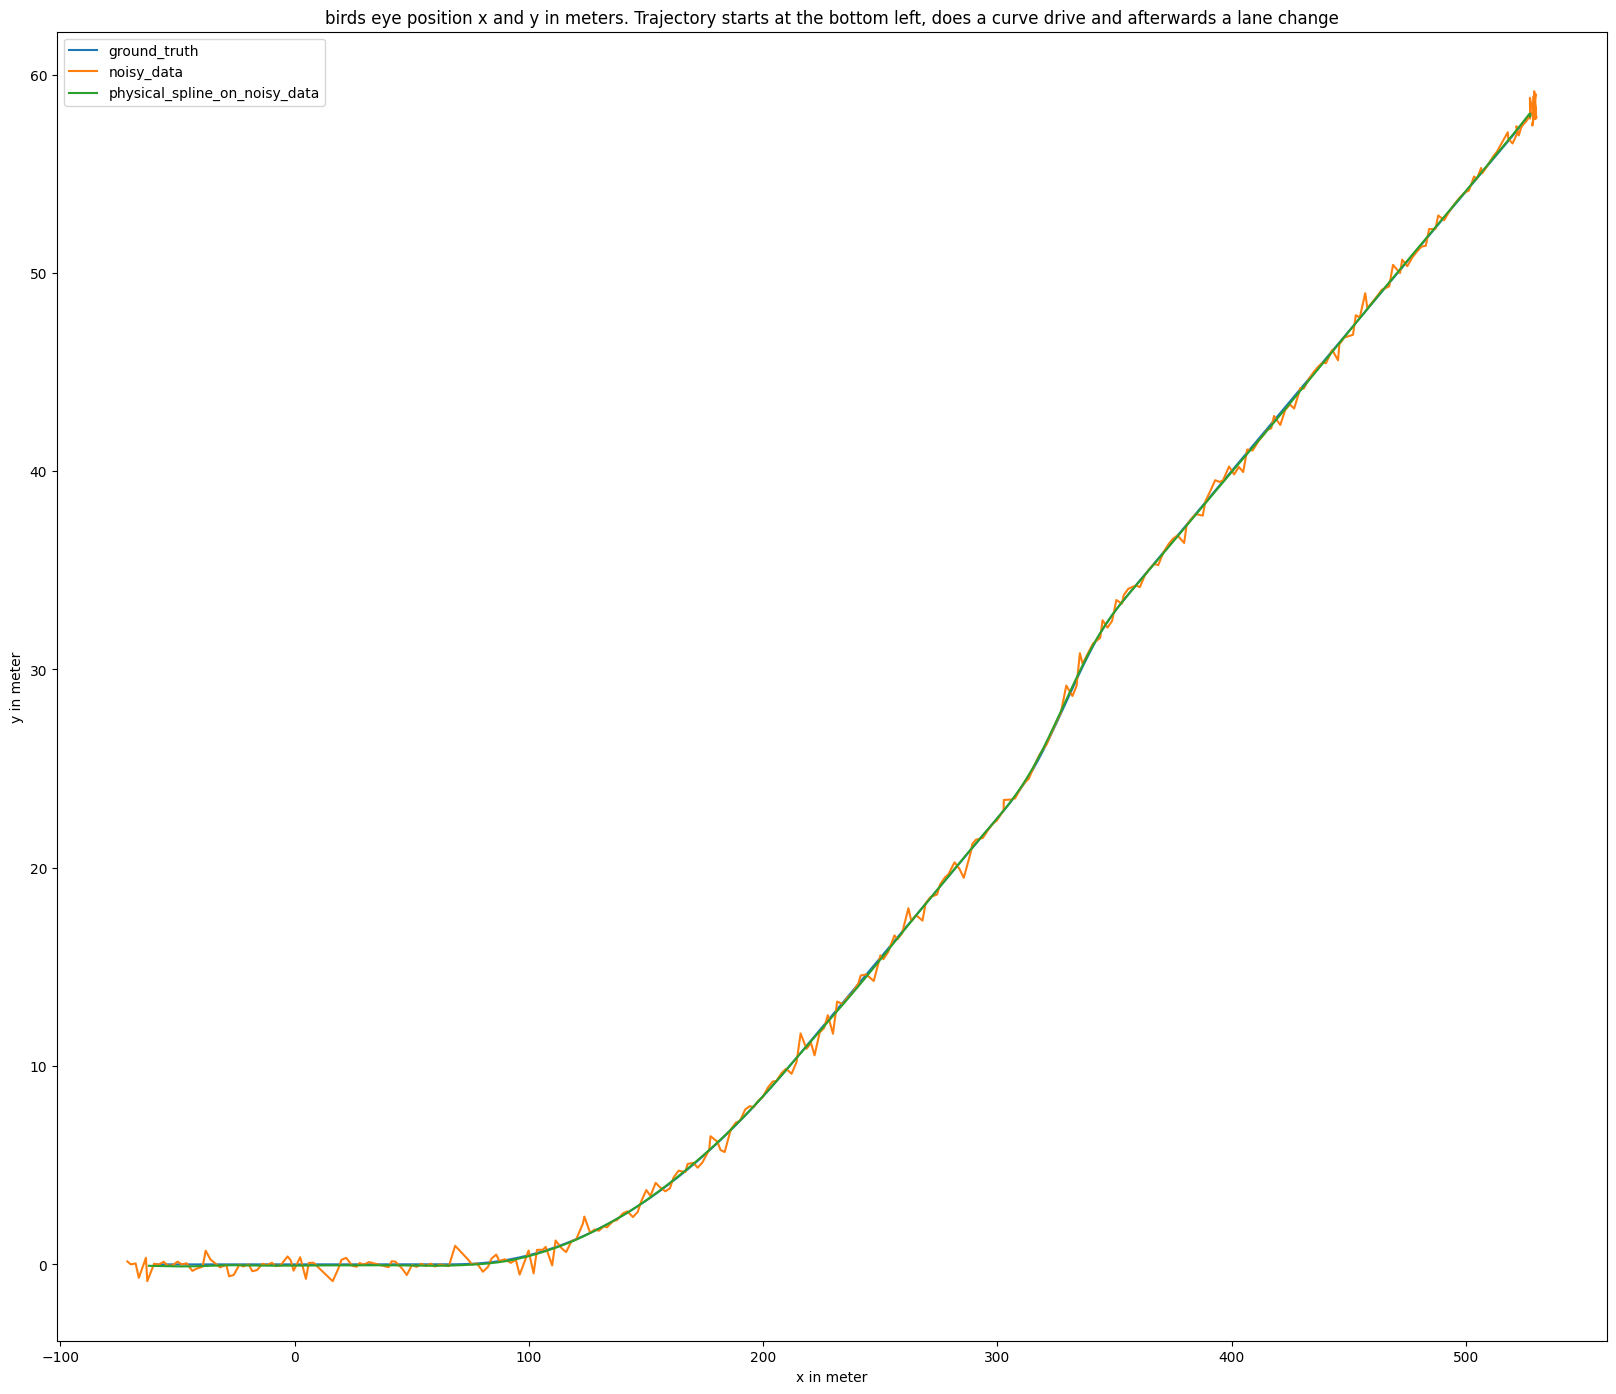

In [11]:
plt.figure(figsize=(20,17))
plt.plot(data['x'],data['y'], label = 'ground_truth')
plt.plot(data['x_noisy'],data['y_noisy'], label = 'noisy_data')
plt.plot(fcn_x(data['time'].tolist()),fcn_y(data['time'].tolist()), label = 'physical_spline_on_noisy_data')
plt.xlabel('x in meter')
plt.ylabel('y in meter')
plt.legend()
plt.title('birds eye position x and y in meters. Trajectory starts at the bottom left, does a curve drive and afterwards a lane change')

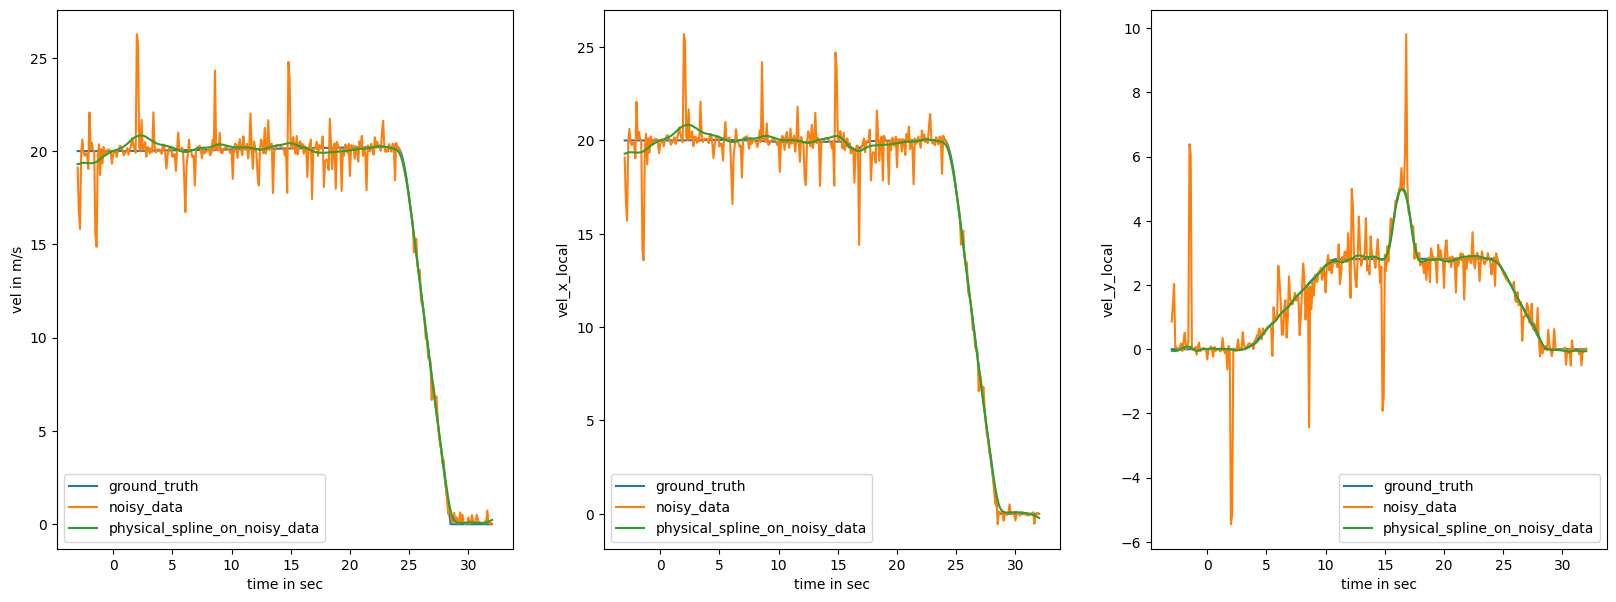

In [12]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.plot(data['time'],np.sqrt(data['xDot']**2+data['yDot']**2),  label = 'ground_truth')
plt.plot(data['time'],np.sqrt(data['xDot_noisy']**2+data['yDot_noisy']**2), label = 'noisy_data')
plt.plot(data['time'],np.sqrt(fcn_x(data['time'].to_numpy(),1)**2+fcn_y(data['time'].to_numpy(),1)**2), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('vel in m/s')
plt.legend()
plt.subplot(1,3,2)
plt.plot(data['time'],data['xDot'],  label = 'ground_truth')
plt.plot(data['time'],data['xDot_noisy'], label = 'noisy_data')
plt.plot(data['time'],fcn_x(data['time'].tolist(),1), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('vel_x_local')
plt.legend()
plt.subplot(1,3,3)
plt.plot(data['time'],data['yDot'],  label = 'ground_truth')
plt.plot(data['time'],data['yDot_noisy'], label = 'noisy_data')
plt.plot(data['time'],fcn_y(data['time'].tolist(),1), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('vel_y_local')
plt.legend()

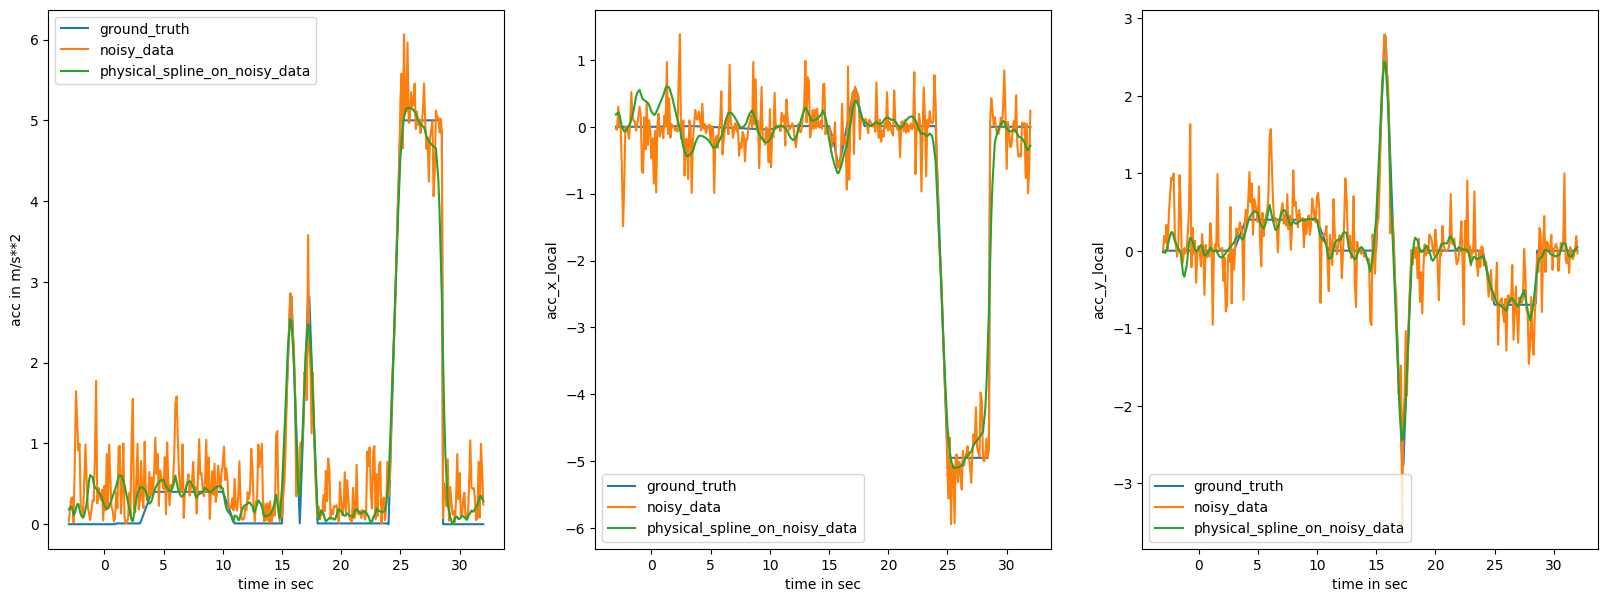

In [13]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.plot(data['time'],np.sqrt(data['xDotDot']**2+data['yDotDot']**2),  label = 'ground_truth')
plt.plot(data['time'],np.sqrt(data['xDotDot_noisy']**2+data['yDotDot_noisy']**2), label = 'noisy_data')
plt.plot(data['time'],np.sqrt(fcn_x(data['time'].to_numpy(),2)**2+fcn_y(data['time'].to_numpy(),2)**2), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('acc in m/s**2')
plt.legend()
plt.subplot(1,3,2)
plt.plot(data['time'],data['xDotDot'],  label = 'ground_truth')
plt.plot(data['time'],data['xDotDot_noisy'], label = 'noisy_data')
plt.plot(data['time'],fcn_x(data['time'].tolist(),2), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('acc_x_local')
plt.legend()
plt.subplot(1,3,3)
plt.plot(data['time'],data['yDotDot'],  label = 'ground_truth')
plt.plot(data['time'],data['yDotDot_noisy'], label = 'noisy_data')
plt.plot(data['time'],fcn_y(data['time'].tolist(),2), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('acc_y_local')
plt.legend()

## Using the heading verison of the physical spline to estimate the heading on top

In [14]:
delta_t = 0.25
k_heading = 1
k_vel = 0.1
k_acc = 0.1
k_pos = 1
reg_0 = 0.1
reg_1 = 0.1
reg_2 = 1

In [15]:
spline_ds_heading = spline_designer.SplineDesignerHeading()
spline_ds_heading.init_constant_resolution(min(data["time"]), max(data["time"]), delta_t)

In [16]:
spline_ds_heading.add_heading_points(data["time"].tolist(), data["yaw_noisy"].tolist(),k_heading)
spline_ds_heading.add_velocities_to_heading(data["time"].to_numpy(), fcn_x(data['time'].to_numpy(),1),fcn_y(data['time'].to_numpy(),1),k_vel)
spline_ds_heading.add_positions_to_heading(data["time"].to_numpy(), fcn_x(data['time'].to_numpy()),fcn_y(data['time'].to_numpy()),k_pos)
spline_ds_heading.add_accelerations_to_heading(data['time'],fcn_x(data['time'].to_numpy(),1),fcn_y(data['time'].to_numpy(),1),fcn_x(data['time'].to_numpy(),2),fcn_y(data['time'].to_numpy(),2),k_acc)

In [17]:
spline_ds_heading.add_coefficient_regularisation(reg_0)
spline_ds_heading.add_coefficient_regularisation(reg_1,1)
spline_ds_heading.add_coefficient_regularisation(reg_2,2)

In [18]:
fcn_heading = spline_ds_heading.get_spline()

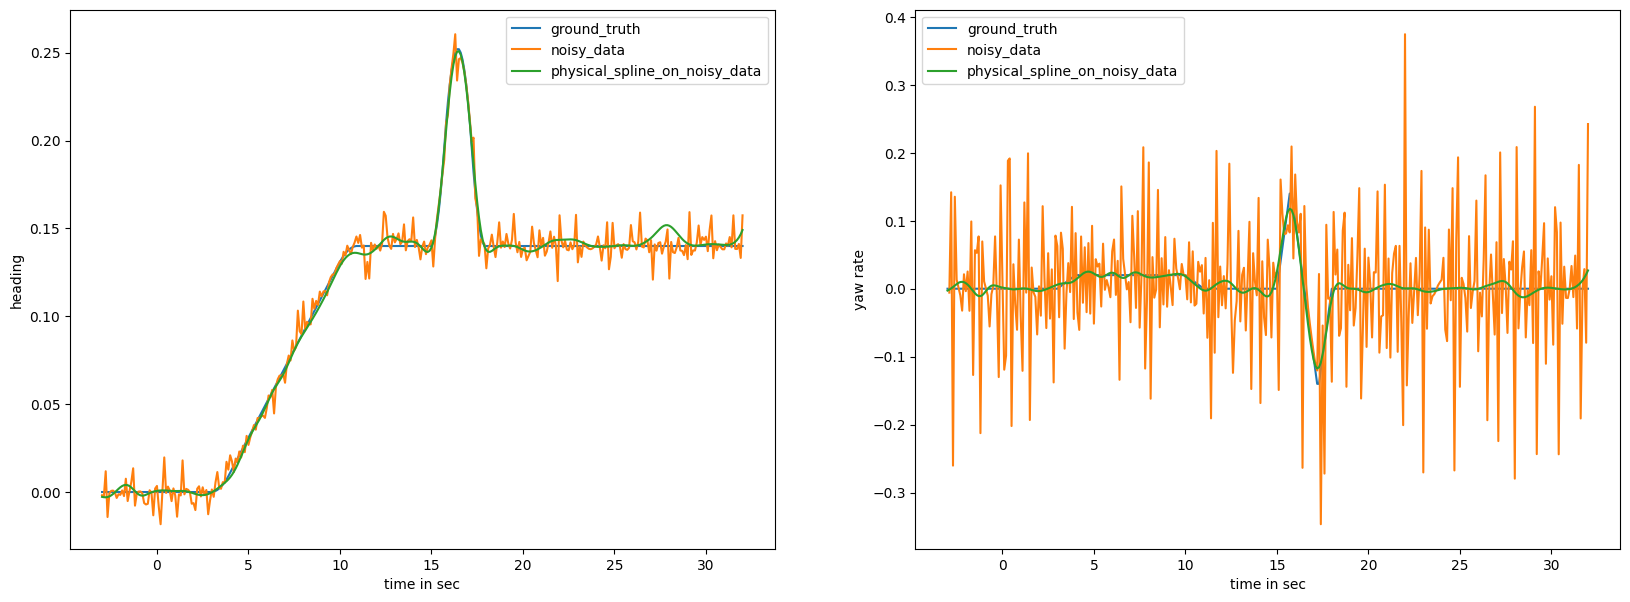

In [19]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(data['time'],data['yaw'],  label = 'ground_truth')
plt.plot(data['time'],data['yaw_noisy'], label = 'noisy_data')
plt.plot(data['time'],fcn_heading(data['time'].tolist()), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('heading')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data['time'],data['yaw_rate'],  label = 'ground_truth')
plt.plot(data['time'],data['yaw_noisy'].diff()/0.1, label = 'noisy_data')
plt.plot(data['time'],fcn_heading(data['time'].tolist(),1), label = 'physical_spline_on_noisy_data')
plt.xlabel('time in sec')
plt.ylabel('yaw rate')
plt.legend()



# Example for connecting two disconnected trajectories

Trajectories could be disconnected due to occlusion. Drawing just a straight line is not that plausible. We can use the physical spline to connect them

In [20]:
data_with_hole = data.query("time < 3 or time > 7 and time < 14")
data_without_hole = data.query("time < 14")

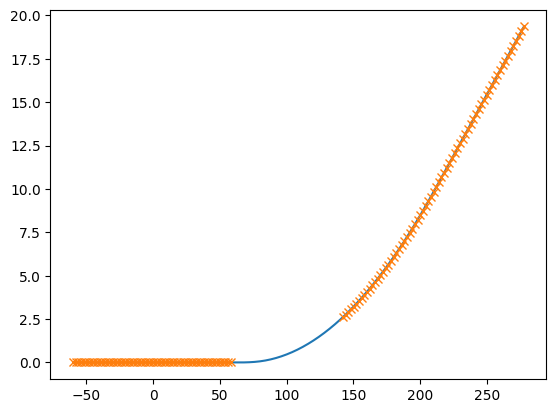

In [21]:
plt.plot(data_without_hole['x'], data_without_hole['y'])
plt.plot(data_with_hole['x'], data_with_hole['y'],'x')

In [22]:
delta_t = 0.25

spline_ds = spline_designer.SplineDesigner2D()
spline_ds.init_constant_resolution(min(data_with_hole["time"]), max(data_with_hole["time"]), delta_t)

spline_ds.add_points(data_with_hole['time'].to_numpy(),data_with_hole['x'].to_numpy(),data_with_hole['y'].to_numpy(),1)
spline_ds.add_points(data_with_hole['time'].to_numpy(),data_with_hole['xDot'].to_numpy(),data_with_hole['yDot'].to_numpy(),1,1)
spline_ds.add_points(data_with_hole['time'].to_numpy(),data_with_hole['xDotDot'].to_numpy(),data_with_hole['yDotDot'].to_numpy(),1,2)

spline_ds.add_coefficient_regularisation(1e-5,0)
spline_ds.add_coefficient_regularisation(1e-5,1)
spline_ds.add_coefficient_regularisation(1e-5,2)

fcn_x, fcn_y = spline_ds.get_spline()


Text(0.5, 1.0, 'Trajectory gets connected way better than straight line in the hole by using the different regularisation conditions')

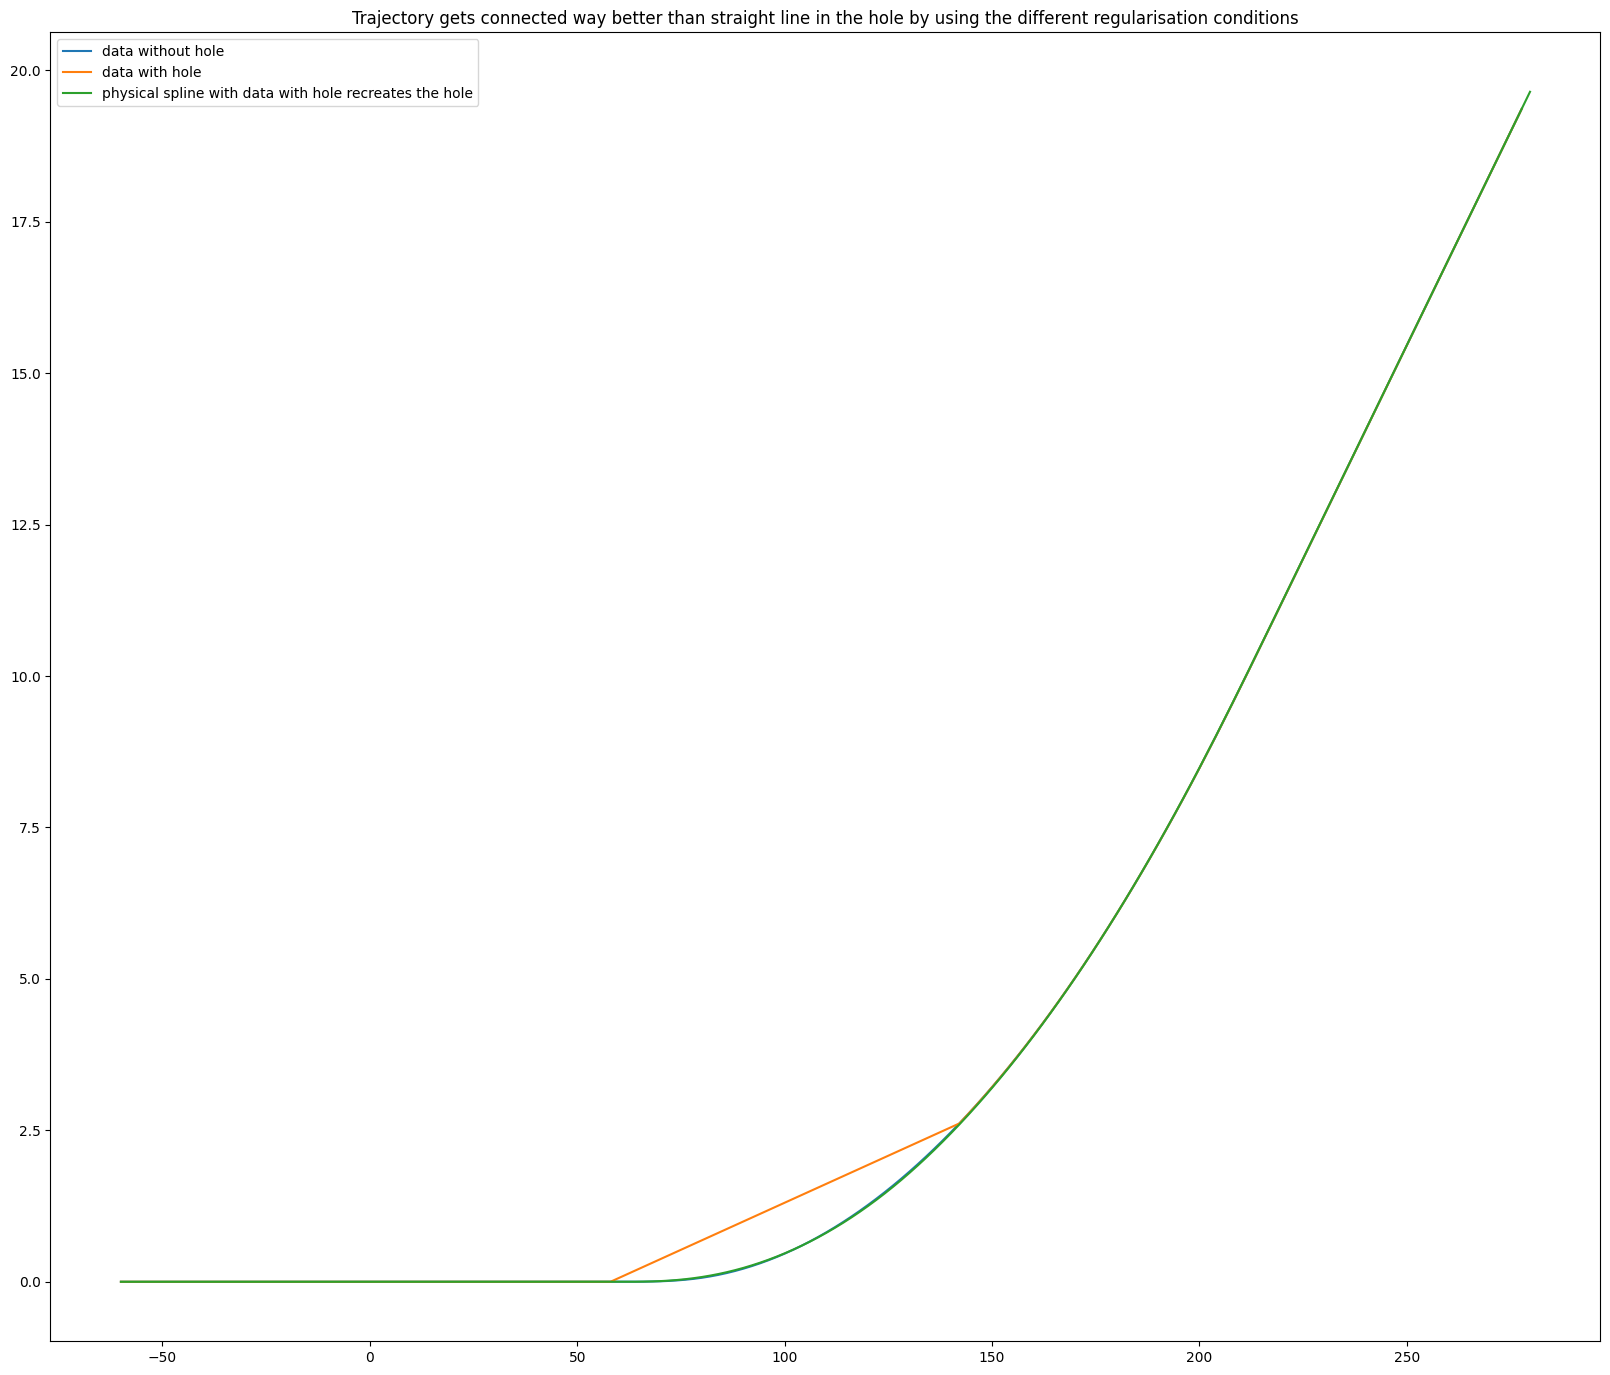

In [23]:
plt.figure(figsize=(20,17))
plt.plot(data_without_hole['x'], data_without_hole['y'], label = 'data without hole')
plt.plot(data_with_hole['x'], data_with_hole['y'], label = 'data with hole')
plt.plot(fcn_x(np.linspace(-3,14,17*10+1)), fcn_y(np.linspace(-3,14,17*10+1)), label = 'physical spline with data with hole recreates the hole')
plt.legend()
plt.title('Trajectory gets connected way better than straight line in the hole by using the different regularisation conditions')

(-2.0, 5.0)

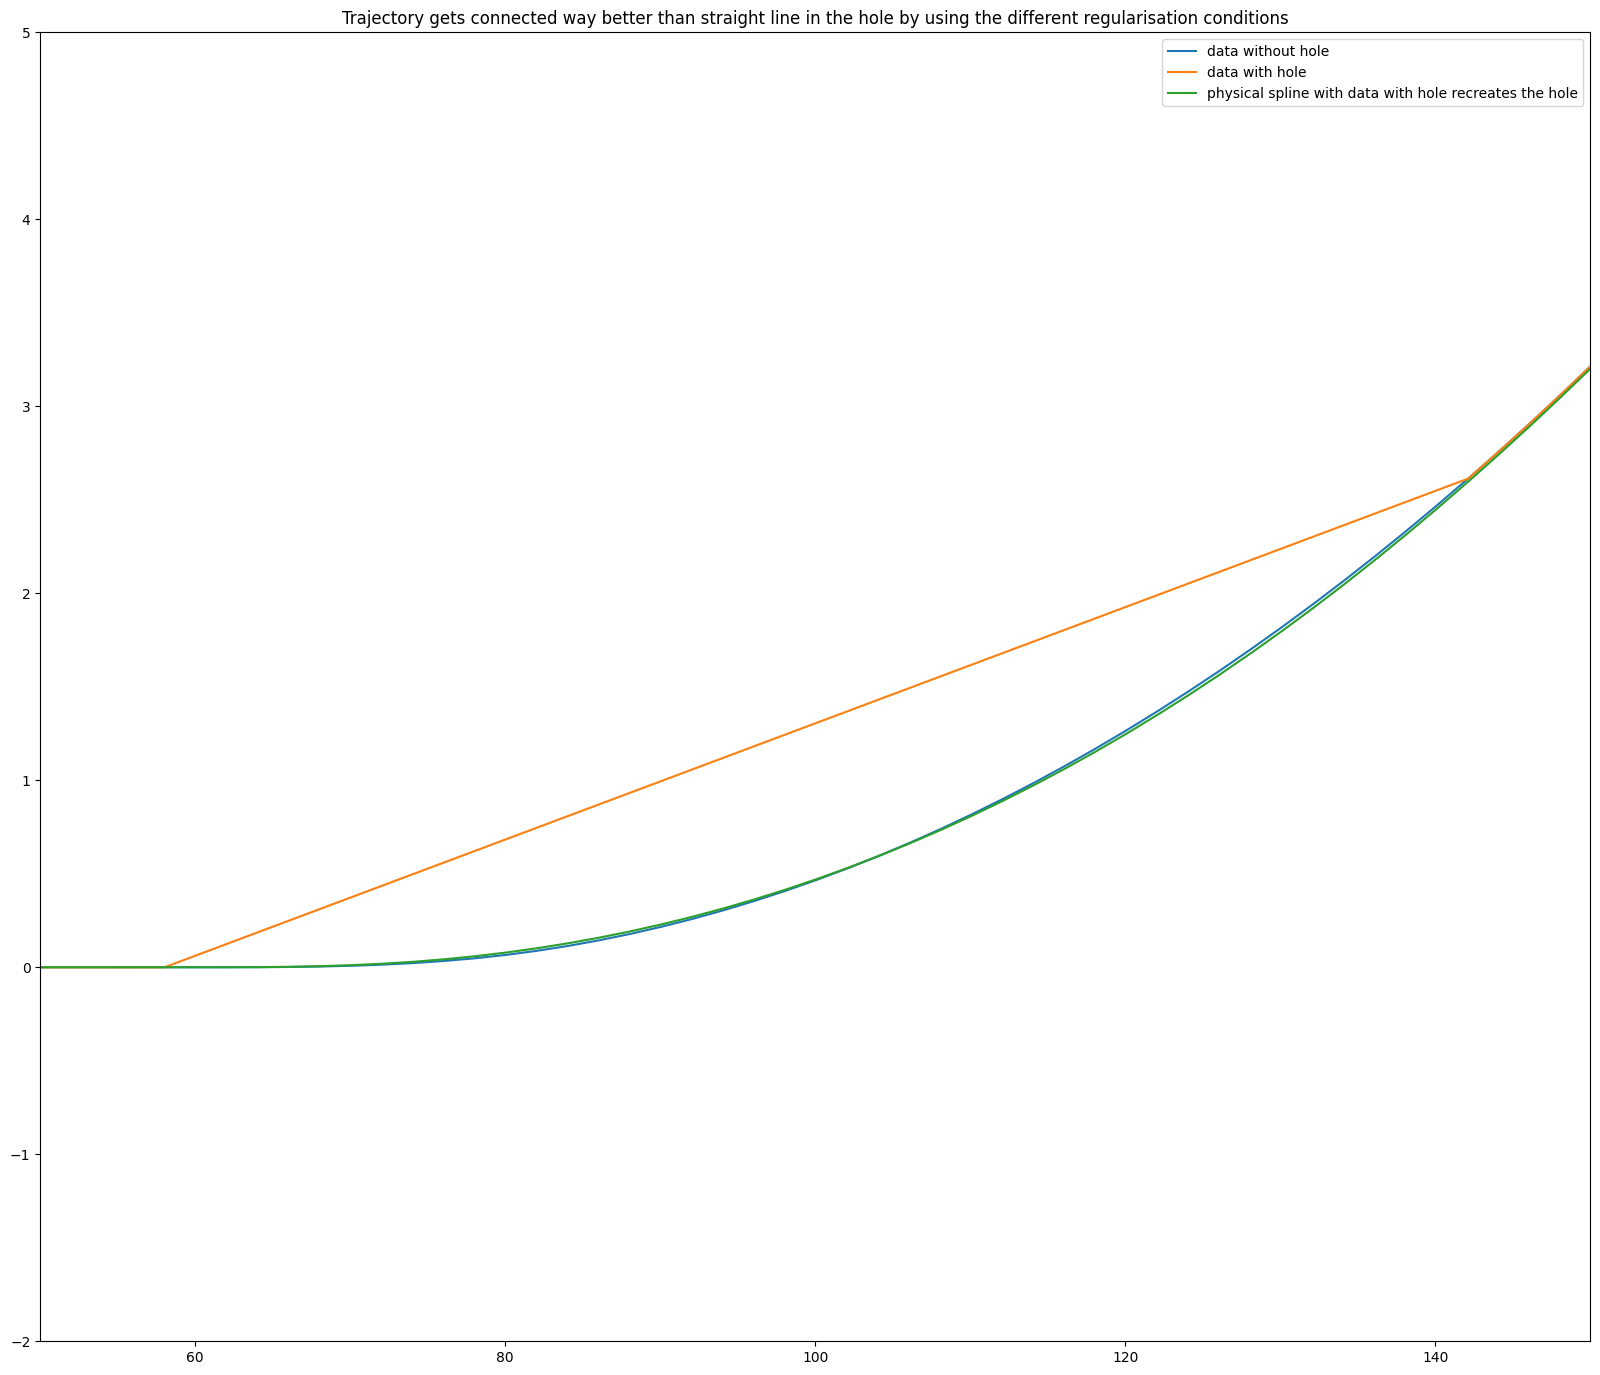

In [24]:
plt.figure(figsize=(20,17))
plt.plot(data_without_hole['x'], data_without_hole['y'], label = 'data without hole')
plt.plot(data_with_hole['x'], data_with_hole['y'], label = 'data with hole')
plt.plot(fcn_x(np.linspace(-3,14,17*10+1)), fcn_y(np.linspace(-3,14,17*10+1)), label = 'physical spline with data with hole recreates the hole')
plt.legend()
plt.title('Trajectory gets connected way better than straight line in the hole by using the different regularisation conditions')
plt.xlim([50,150])
plt.ylim([-2,5])